## Triggered LFP


For this tutorial we use a dataset from chronic recordings collected for Steinmetz et al. 2021. This is a subset of the data available [here](https://rdr.ucl.ac.uk/articles/dataset/Chronic_recordings_from_Neuropixels_2_0_probes_in_mice/24411841).

The dataset was collected by _Anna Lebedeva_ in the Carandini/Harris lab at UCL from animal _AL032_, and prepared by _Jennifer Colonell_ (HHMI, Janelia). 

**Only data from shank0 and recording day 2019-11-21 are provided.**

For experimental details about the recording (specifically: the experiment in Figure 4 of the paper, Supplementary methods 1.2 Chronic recordings in Carandini/Harris Lab at UCL)

Read more about [Current Source Density](https://www.neuroinf.pl/Members/danek/homepage/preprints/Article.2013-12-16.4021/getFile)


In [4]:
from pathlib import Path
import numpy as np 
import pylab as plt
from helpers import *
# for interactivity
%matplotlib ipympl 

foldername = Path('Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0')  # path to folder containing the binary file
# try to find the binary file (has extension .bin)
fname = list(foldername.rglob('*.bin'))
if not len(fname): # display an error message if the file is not found.
    raise(ValueError(f'Could not find the file in folder {foldername}'))
else:
    fname = fname[0] # the full path to the file

# load the binary file
dat,meta = load_spikeglx_binary(fname)

# get the units conversion factors
digitizer_range_volts = meta['imAiRangeMax'] # of niAiRangeMax for NI streams or obAiRangeMax for onebox streams
digitizer_max_value = meta['imMaxInt'] # or niMaxInt for NI streams or obMaxInt for onebox stream

# the gain is fixed for NP2 but variable for 1.0 probes
if int(meta['imDatPrb_type']) in [21,24]:
    gain = 80
elif int(meta['imDatPrb_type']) in [2013]:
    gain = 100

gain = 500 #500 is for neuropixel 1.0

conversion_factor = digitizer_range_volts/digitizer_max_value/gain * 1e6 # convert to microvolt my multiplying by 1e6

sampling_rate = meta['imSampRate'] # from the .meta

# outfolder = Path('./data/AL032/')
# from scipy.io import loadmat # load matlab files in python
# mat = loadmat(outfolder.parent/'AL032_stimulus/AL032_stimulus_times.mat',squeeze_me=True)
# # get the stim times
# stimtimes = mat['sorted_response'][np.where(mat['day_label'] == '2019-11-21')].squeeze()
# stimtimes = np.stack(stimtimes) # ntrial x nstim x feature

stimon_times = np.load(r'C:\Users\NeuropixelsComp\Documents\GitHub\python_npx\stimon_times.npy')



<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
C:\Users\NeuropixelsComp\AppData\Local\Temp\ipykernel_35392\3684538842.py:8: SyntaxWarning: invalid escape sequence '\S'
  foldername = Path('Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0')  # path to folder containing the binary file


Skipping ['catGTCmdline0', '<CatGT -dir', 'Y:/SGL_DATA_drive -run', 'wmm001_250705_rec_d12 -g', '0,2 -t', '0 -prb_fld -ni -ap -prb', '0 -apfilter', 'butter,12,300,10000 -lffilter', 'butter,12,1,500 -gblcar -gfix', '0.4,0.1,0.02 -xa', '0,0,0,1,3,500 -xia', '0,0,1,3,3,0 -xd', '0,0,-1,1,50 -xid', '0,0,-1,2,1.7 -xid', '0,0,-1,3,5 -dest', 'Y:/SGL_DATA_drive/wmm001_250705_rec_d12 -out_prb_fld>\n']


Get triggered LFP, we will extract the average first. 


In [5]:
def lfp_filter(X,freq_low = 3., freq_high = 150, original_sampling_rate = 30000, downsampling_rate = 5000):
    # define a function to perform the filtering (isolate the LF band and downsample)
    from scipy.signal import butter, filtfilt, decimate
    Wn = np.array([freq_low,freq_high]) / (original_sampling_rate/2.) # define the filter band
    b, a = butter(3, Wn, btype = 'band') # third order butterworth filter
    nX = filtfilt(b,a,X, axis = 0) # use 2 passes
    return decimate(nX,int(original_sampling_rate/downsampling_rate),axis = 0)

tpre = -0.3
tpost = 0.3
idx = np.arange(tpre*sampling_rate, tpost*sampling_rate, dtype = int)

time = np.arange(len(dat))/sampling_rate


#get the channelmap from the snsGeomMap 
cmap = np.stack([[int(a) for a in s.split(':')] for s in meta['snsGeomMap'][1:]])
cmap = cmap[cmap[:,0]==0,:][:,[1,2]] # shank zero
# sort the depth and get every other channel because we are taking a single column
channelidx = np.argsort(cmap[:,1])
cmap = cmap[channelidx]
channelidx = channelidx[cmap[:,0]==np.min(cmap[:,0])]
cmap = cmap[cmap[:,0]==np.min(cmap[:,0]),:]


# get all trials
trial_lfp = []
# stimtimes[:,:,1] should just be stimon_times
# for t_stim in tqdm(stimtimes[:,:,1].flatten()):
for t_stim in tqdm(stimon_times):
    t_sample = np.where(time<=t_stim)[0][-1]
    chunk = dat[t_sample+idx,:-1][:,channelidx] # drop the sync channel
    trial_lfp.append(lfp_filter(chunk))
trial_lfp = np.stack(trial_lfp)

100%|██████████| 471/471 [06:20<00:00,  1.24it/s]


=== LFP Data Diagnostics ===
trial_lfp shape: (471, 3001, 96)
avg_lfp shape: (96, 3001)
conversion_factor: 2.34375

Raw avg_lfp stats (before conversion):
  Min: -0.674798, Max: 0.720100
  Mean: 0.000725, Std: 0.038327

Converted avg_lfp stats (after conversion, in μV):
  Min: -1.58 μV, Max: 1.69 μV
  Mean: 0.00 μV, Std: 0.09 μV

Current color scale limits: [-20, 20] μV
Data range covers 100.0% of color scale
Any NaN values: False
Any Inf values: False


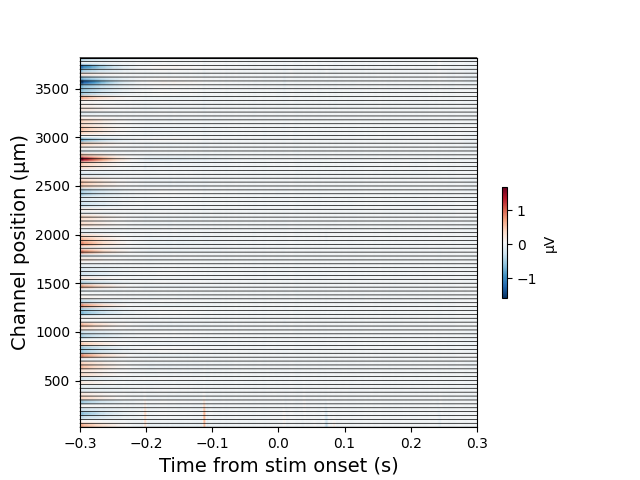

In [8]:
# average LFP
avg_lfp = trial_lfp.mean(axis = 0).T

# Check LFP data statistics
print("=== LFP Data Diagnostics ===")
print(f"trial_lfp shape: {trial_lfp.shape}")
print(f"avg_lfp shape: {avg_lfp.shape}")
print(f"conversion_factor: {conversion_factor}")
print(f"\nRaw avg_lfp stats (before conversion):")
print(f"  Min: {avg_lfp.min():.6f}, Max: {avg_lfp.max():.6f}")
print(f"  Mean: {avg_lfp.mean():.6f}, Std: {avg_lfp.std():.6f}")
print(f"\nConverted avg_lfp stats (after conversion, in μV):")
avg_lfp_uv = avg_lfp * conversion_factor
print(f"  Min: {avg_lfp_uv.min():.2f} μV, Max: {avg_lfp_uv.max():.2f} μV")
print(f"  Mean: {avg_lfp_uv.mean():.2f} μV, Std: {avg_lfp_uv.std():.2f} μV")
print(f"\nCurrent color scale limits: [-20, 20] μV")
print(f"Data range covers {100*((avg_lfp_uv >= -20) & (avg_lfp_uv <= 20)).sum() / avg_lfp_uv.size:.1f}% of color scale")
print(f"Any NaN values: {np.isnan(avg_lfp).any()}")
print(f"Any Inf values: {np.isinf(avg_lfp).any()}")

t = np.linspace(tpre,tpost,avg_lfp.shape[1])
plt.figure()

# Use adaptive color limits based on data range, or let matplotlib auto-scale
# For now, try auto-scaling first to see the data
plt.imshow(avg_lfp*conversion_factor,aspect = 'auto',
           extent = [tpre,tpost,cmap[0,1],cmap[-1,1]],
           cmap = 'RdBu_r')  # Removed clim to see actual data range
# Uncomment below to set specific limits if needed:
# plt.imshow(avg_lfp*conversion_factor,aspect = 'auto',
#            extent = [tpre,tpost,cmap[0,1],cmap[-1,1]],
#            clim = [-20,20], cmap = 'RdBu_r')
plt.colorbar(shrink = 0.3,label = 'μV')

for p,depth in zip(avg_lfp[::1],cmap[::1,1]):
     plt.plot(t,p/10+depth,'k',lw = 0.5,clip_on = False)
plt.ylim([cmap[0,1],cmap[-1,1]])
# plt.xticks([])
plt.ylabel('Channel position (μm)',fontsize = 14)
plt.xlabel('Time from stim onset (s)',fontsize = 14);


The current source density is the second spatial derivative of the LFP.

The supplementary methods of _Laminar Structure of Spontaneous and Sensory-Evoked Population Activity in Auditory Cortex_ has a nice description on how to compute it [Sakata and Harris 2009](https://www.sciencedirect.com/science/article/pii/S089662730900720X)

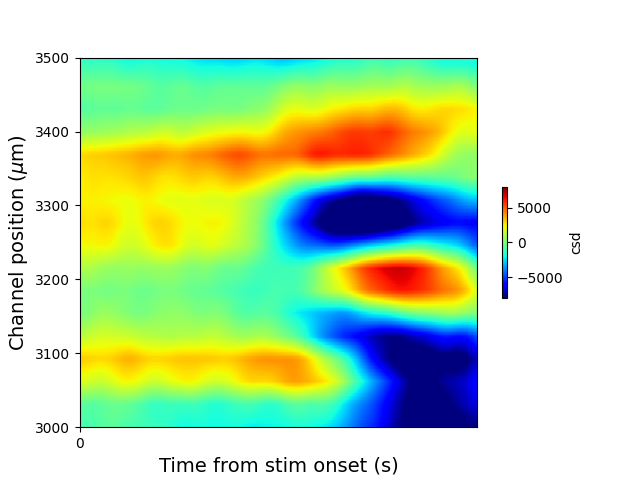

In [33]:
# CSD
def current_source_density(lfp,chmap, interpolation_chanspacing=30):
    # Interpolate so that we get even sampling
    ux = np.unique(chmap[:,0])
    ix = np.argmax([np.sum(chmap[:,0]==u) for u in ux])
    chidx = chmap[:,0]==ux[ix]
    y = np.array(chmap[chidx,1])
    duration = lfp.shape[1]
    x = np.arange(duration)
    z = lfp[:,:]
    from scipy.interpolate import RegularGridInterpolator
    f = RegularGridInterpolator((x, y), z.T,bounds_error=False,method='nearest')
    # f = interp2d(x,y,z)
    ny = np.arange(np.min(y)-interpolation_chanspacing,np.max(y)+interpolation_chanspacing,interpolation_chanspacing)
    xxnew, yynew = np.meshgrid(x,ny, indexing='ij')
    nlfp = f((xxnew,yynew)).T
    # duplicate outmost channels
    csd = np.empty((nlfp.shape[0]-2,nlfp.shape[1]))
    smoothed_lfp = np.empty_like(nlfp)
    for i in range(csd.shape[0]):
        smoothed_lfp[i+1,:] = (1./4.) *(nlfp[i,:] + 2.*nlfp[i+1,:] + nlfp[i+2,:])
    smoothed_lfp[0,:] = (1./4.) *(3.*nlfp[0,:] + nlfp[1,:])
    smoothed_lfp[-1,:] = (1./4.) *(3.*nlfp[-1,:] + nlfp[-2,:])
    for i in range(csd.shape[0]):
        csd[i,:] = -(1./(interpolation_chanspacing*1.e-3)**2.)*(smoothed_lfp[i,:]-2.*smoothed_lfp[i+1,:]+smoothed_lfp[i+2,:])
    
    a,b,z = (x,np.linspace(np.min(y)-interpolation_chanspacing,np.max(y)+interpolation_chanspacing,csd.shape[0]),csd)
    f = RegularGridInterpolator((a, b), z.T,bounds_error=False)
    ny = np.arange(np.min(y)-interpolation_chanspacing,np.max(y)+interpolation_chanspacing,5.)
    xxnew, yynew = np.meshgrid(x,ny, indexing='ij')

    return f((xxnew,yynew)).T,smoothed_lfp[:,1:-1]


t = np.linspace(tpre,tpost,avg_lfp.shape[0])
plt.figure()
csd,smoothlfp = current_source_density(avg_lfp*conversion_factor,cmap)
plt.imshow(csd,aspect = 'auto',
        extent = [tpre,tpost,cmap[0,1],cmap[-1,1]], cmap = 'jet',clim = [-8000,8000])
cb = plt.colorbar(shrink = 0.3,label = 'csd')

plt.ylim([cmap[0,1],cmap[-1,1]])
plt.ylabel('Channel position ($\mu$m)',fontsize = 14)
plt.xlabel('Time from stim onset (s)',fontsize = 14);
plt.xlim([-0.0,0.07])
plt.xticks([0])
plt.ylim([3000,3500]);
